In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import catboost as cat
import numpy as np
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
# from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from category_encoders import TargetEncoder 
import optuna

/Users/andrejurkinair/Documents/diploma_practice/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("../../datasets/coffee_shop_dataset/coffee_shop_revenue.csv")
target = "Daily_Revenue"

num_features = list(df.select_dtypes(exclude='object'))
num_features.remove(target)
cat_features = list(df.select_dtypes(include='object'))
catboost_features = num_features+cat_features

In [3]:
result_metrics = pd.DataFrame(columns=[
     'algorithm',
     'dataset_type',
     'R2',
     'MSE',
     'RMSE',
     'MAE',
     'MAPE'
])

In [4]:
def get_metrics(y_true, y_pred, algorithm, dataset_type, res_df=None):
    res_df = res_df.copy()
    
    r2 = metrics.r2_score(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    mae = metrics.mean_absolute_error(y_true, y_pred)
    mape = metrics.mean_absolute_percentage_error(y_true, y_pred)

    print(f"{algorithm}, -- Type Dataset - {dataset_type}")
    print(f"R2 = {r2}")
    print(f"MSE = {mse}")
    print(f"RMSE = {mse**0.5}")
    print(f"MAE = {mae}")
    print(f"MAPE = {mape}")
    
    curr_res = [algorithm, dataset_type] + [r2, mse, mse**0.5, mae, mape]
    res_df = pd.concat([res_df,
                        pd.DataFrame([curr_res], columns=['algorithm',
                                                            'dataset_type',
                                                            'R2',
                                                            'MSE',
                                                            'RMSE',
                                                            'MAE',
                                                            'MAPE'])])
    return res_df

# Dataset preprocessing

In [5]:
df.loc[:, num_features] = df.loc[:, num_features].fillna(0)
df.loc[:, cat_features] = df.loc[:, cat_features].fillna('Other')

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    df[num_features+cat_features], 
    df[[target]], 
    test_size=0.33, random_state=2025)

# 3. Кодирование категориальных признаков
encoder = TargetEncoder(cols=cat_features)
X_train_encoded = encoder.fit_transform(X_train, y_train)
X_test_encoded = encoder.transform(X_test)

scaler = MinMaxScaler()
scaled_X_train_encoded = scaler.fit_transform(X_train_encoded)
scaled_X_train_encoded = pd.DataFrame(scaled_X_train_encoded , columns=catboost_features)
df_train = pd.concat([scaled_X_train_encoded.reset_index(drop=True), 
                      y_train.reset_index(drop=True)], axis=1)

scaled_X_test_encoded = scaler.transform(X_test_encoded[catboost_features])
scaled_X_test_encoded = pd.DataFrame(scaled_X_test_encoded , columns=catboost_features)
df_test = pd.concat([scaled_X_test_encoded.reset_index(drop=True), 
                     y_test.reset_index(drop=True)], axis=1)

linear_features = catboost_features

scaler = MinMaxScaler()
scaled_df_train = scaler.fit_transform(df_train[linear_features])
scaled_df_train = pd.DataFrame(scaled_df_train, columns=linear_features)
scaled_df_train = pd.concat([scaled_df_train, df_train[[target]]], axis=1)

scaled_df_test = scaler.transform(df_test[linear_features])
scaled_df_test = pd.DataFrame(scaled_df_test, columns=linear_features)
scaled_df_test = pd.concat([scaled_df_test, df_test[[target]]], axis=1)

# check K-means clustering

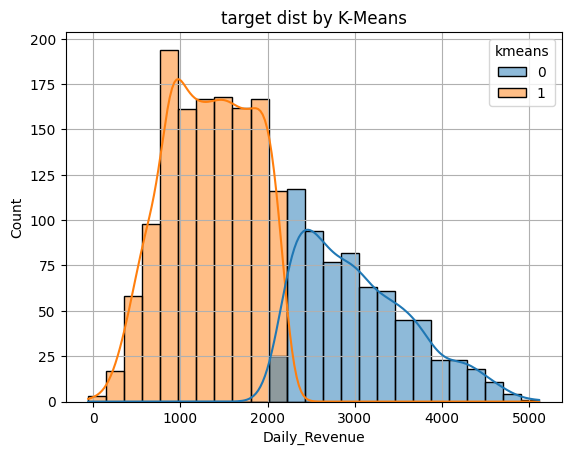

In [7]:
kmeans = KMeans(n_clusters=2, random_state=2025)
kmeans.fit(scaled_df_train[[target]])
clf_target ='kmeans'

scaled_df_train['kmeans'] = kmeans.predict(scaled_df_train[[target]])
scaled_df_test['kmeans'] = kmeans.predict(scaled_df_test[[target]])
kmeans_data = pd.concat([scaled_df_train, scaled_df_test])

plt.title('target dist by K-Means')
plt.grid(which='major')
sns.histplot(data = kmeans_data, x=target, kde=True, hue='kmeans', bins=25)
plt.show()

In [8]:
def objective(trial, X, y):
    # Разделение данных на train и validation
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2025, stratify=y)
    
    # Параметры для перебора
    params = {
        'iterations': trial.suggest_int('iterations', 100, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'random_strength': trial.suggest_float('random_strength', 1e-3, 10, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 10.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations', 1, 15),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'boosting_type': 'Plain',  # Оставим только Plain для стабильности
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        'od_wait': trial.suggest_int('od_wait', 10, 50),
        'one_hot_max_size': trial.suggest_int('one_hot_max_size', 2, 255),
        'eval_metric': 'AUC',
        'task_type': 'CPU',
        'verbose': False,
        'random_state': 2025,
    }
    
    # Параметры глубины в зависимости от политики роста
    if params['grow_policy'] == 'Lossguide':
        params['max_leaves'] = trial.suggest_int('max_leaves', 4, 64)
    elif params['grow_policy'] == 'Depthwise':
        params['max_depth'] = trial.suggest_int('max_depth', 2, 12)
    # Для SymmetricTree глубина контролируется автоматически
    
    # Явное указание категориальных признаков (если есть)
    # if categorical_features:
    #     params['cat_features'] = categorical_features
    
    # Создание и обучение модели
    model = cat.CatBoostClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=(X_val, y_val),
        verbose=0
    )
    
    # Предсказание на валидации
    y_pred = model.predict_proba(X_val)[:, 1]
    
    # Метрика качества
    auc = metrics.roc_auc_score(y_val, y_pred)
    return auc

# Пример использования:
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, 
                                     scaled_df_train[catboost_features], 
                                     scaled_df_train[clf_target]), 
                                     n_trials=50)
best_params = study.best_params

[I 2025-04-25 23:09:25,574] A new study created in memory with name: no-name-6294924c-31db-4449-a878-3e78c50c9068
[I 2025-04-25 23:09:26,347] Trial 0 finished with value: 0.9825839920948617 and parameters: {'iterations': 567, 'learning_rate': 0.29812201632113683, 'l2_leaf_reg': 7.305210175351432, 'random_strength': 0.002368401930955743, 'bagging_temperature': 1.3064532243826976, 'border_count': 33, 'min_data_in_leaf': 3, 'leaf_estimation_iterations': 9, 'grow_policy': 'Lossguide', 'od_type': 'IncToDec', 'od_wait': 19, 'one_hot_max_size': 111, 'max_leaves': 50}. Best is trial 0 with value: 0.9825839920948617.
[I 2025-04-25 23:09:26,730] Trial 1 finished with value: 0.9856719367588933 and parameters: {'iterations': 323, 'learning_rate': 0.003258995036057633, 'l2_leaf_reg': 0.0013641230321686706, 'random_strength': 0.03853784735174532, 'bagging_temperature': 1.2651340859757354, 'border_count': 205, 'min_data_in_leaf': 23, 'leaf_estimation_iterations': 15, 'grow_policy': 'Depthwise', 'od_t

In [9]:
clf = cat.CatBoostClassifier(random_state=2025, cat_features=cat_features, verbose=False, **best_params)
clf.fit(scaled_df_train[catboost_features], scaled_df_train[clf_target])

clf_pred_train = clf.predict(scaled_df_train[catboost_features])
clf_pred_test = clf.predict(scaled_df_test[catboost_features])

print("TRAIN")
print(metrics.classification_report(scaled_df_train[clf_target], clf_pred_train))
print("TEST")
print(metrics.classification_report(scaled_df_test[clf_target], clf_pred_test))
print("train roc auc = ", metrics.roc_auc_score(scaled_df_train[clf_target], clf_pred_train))
print("train roc auc = ", metrics.roc_auc_score(scaled_df_test[clf_target], clf_pred_test))

TRAIN
              precision    recall  f1-score   support

           0       0.95      0.90      0.92       461
           1       0.95      0.97      0.96       879

    accuracy                           0.95      1340
   macro avg       0.95      0.94      0.94      1340
weighted avg       0.95      0.95      0.95      1340

TEST
              precision    recall  f1-score   support

           0       0.92      0.89      0.90       228
           1       0.94      0.96      0.95       432

    accuracy                           0.93       660
   macro avg       0.93      0.92      0.93       660
weighted avg       0.93      0.93      0.93       660

train roc auc =  0.9375942391645011
train roc auc =  0.923306530214425


In [10]:
scaled_df_train_0 = scaled_df_train[scaled_df_train[clf_target] == 0]
scaled_df_train_1 = scaled_df_train[scaled_df_train[clf_target] == 1]

lr_0 = LinearRegression()
lr_0.fit(scaled_df_train_0[linear_features], scaled_df_train_0[target])
pred_train_0 = lr_0.predict(scaled_df_train_0[linear_features])

lr_1 = LinearRegression()
lr_1.fit(scaled_df_train_1[linear_features], scaled_df_train_1[target])
pred_train_1 = lr_1.predict(scaled_df_train_1[linear_features])

print("train", scaled_df_train_0.shape, scaled_df_train_1.shape)
result_metrics = get_metrics(pd.concat([scaled_df_train_0[target], 
                                        scaled_df_train_1[target]]),
                             np.hstack([pred_train_0, pred_train_1]),
                              algorithm='segm_kmeans2_regression', dataset_type='train', 
                              res_df=result_metrics)


train (461, 8) (879, 8)
segm_kmeans2_regression, -- Type Dataset - train
R2 = 0.9411332858527829
MSE = 56495.04985524939
RMSE = 237.68687354426913
MAE = 190.76832823276598
MAPE = 0.15505722860348586


/var/folders/dy/q_kmpbjj54q1glfr1wthxzhw0000gn/T/ipykernel_51645/2903524573.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res_df = pd.concat([res_df,


In [11]:
mask_0 = clf.predict_proba(scaled_df_test[catboost_features])[:, 1]<=0.4
mask_1 = clf.predict_proba(scaled_df_test[catboost_features])[:, 1]>=0.6
mask_doubting = ~mask_1 & ~mask_0

scaled_df_test_0 = scaled_df_test.loc[mask_0]
scaled_df_test_1 = scaled_df_test.loc[mask_1]
scaled_df_test_doubting = scaled_df_test.loc[mask_doubting]

pred_test_0 = lr_0.predict(scaled_df_test_0[linear_features])
pred_test_1 = lr_1.predict(scaled_df_test_1[linear_features])

if scaled_df_test_doubting.shape[0]>0:
     pred_test_doubting = (
          clf.predict_proba(scaled_df_test_doubting[catboost_features])[:,0]*lr_0.predict(scaled_df_test_doubting[linear_features]) +\
          clf.predict_proba(scaled_df_test_doubting[catboost_features])[:,1]*lr_1.predict(scaled_df_test_doubting[linear_features])
     )
else: 
     pred_test_doubting = np.array([])

result_metrics = get_metrics(pd.concat([scaled_df_test_0[target], 
                                        scaled_df_test_doubting[target], 
                                        scaled_df_test_1[target]]),
                             np.hstack([pred_test_0, pred_test_doubting, pred_test_1]),
                              algorithm='segm_kmeans2_regression', dataset_type='test', 
                              res_df=result_metrics)

segm_kmeans2_regression, -- Type Dataset - test
R2 = 0.9359064488723309
MSE = 60108.257078209404
RMSE = 245.16985352650804
MAE = 195.1334685280337
MAPE = 0.13907598816608505


In [12]:
result_metrics 

,algorithm,dataset_type,R2,MSE,RMSE,MAE,MAPE
0,segm_kmeans2_regression,train,0.941133,56495.049855,237.686874,190.768328,0.155057
0,segm_kmeans2_regression,test,0.935906,60108.257078,245.169854,195.133469,0.139076


# check spectral clustering

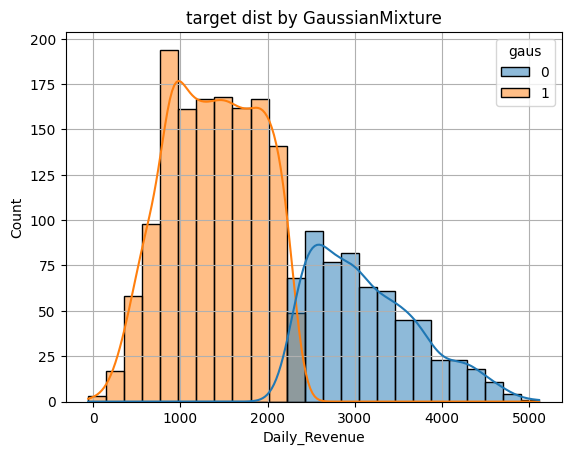

In [ ]:
gaus = GaussianMixture(n_components=2, random_state=2025)
gaus.fit(scaled_df_train[[target]])
clf_target ='gaus'

scaled_df_train['gaus'] = gaus.predict(scaled_df_train[[target]])
scaled_df_test['gaus'] = gaus.predict(scaled_df_test[[target]])
gaus_data = pd.concat([scaled_df_train, scaled_df_test])

plt.title('target dist by GaussianMixture')
plt.grid(which='major')
sns.histplot(data = gaus_data, x=target, kde=True, hue='gaus', bins=25)
plt.show()

In [14]:
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, 
                                     scaled_df_train[catboost_features], 
                                     scaled_df_train[clf_target]), 
                                     n_trials=50)
best_params = study.best_params

[I 2025-04-25 23:09:40,089] A new study created in memory with name: no-name-2f33e01e-42e8-46ce-97d3-60d4782fbfab
[I 2025-04-25 23:09:41,090] Trial 0 finished with value: 0.9918699186991871 and parameters: {'iterations': 1385, 'learning_rate': 0.09257564421581431, 'l2_leaf_reg': 0.0037215736868191477, 'random_strength': 1.3856203080513503, 'bagging_temperature': 8.76071340475609, 'border_count': 187, 'min_data_in_leaf': 87, 'leaf_estimation_iterations': 1, 'grow_policy': 'Lossguide', 'od_type': 'IncToDec', 'od_wait': 32, 'one_hot_max_size': 228, 'max_leaves': 38}. Best is trial 0 with value: 0.9918699186991871.
[I 2025-04-25 23:09:41,278] Trial 1 finished with value: 0.9889194859690532 and parameters: {'iterations': 1964, 'learning_rate': 0.01400125223256953, 'l2_leaf_reg': 0.5329645998941333, 'random_strength': 0.013967082407348305, 'bagging_temperature': 4.883503436159105, 'border_count': 229, 'min_data_in_leaf': 60, 'leaf_estimation_iterations': 6, 'grow_policy': 'Lossguide', 'od_ty

In [15]:
clf = cat.CatBoostClassifier(random_state=2025, cat_features=cat_features, verbose=False, **best_params)
clf.fit(scaled_df_train[catboost_features], scaled_df_train[clf_target])

clf_pred_train = clf.predict(scaled_df_train[catboost_features])
clf_pred_test = clf.predict(scaled_df_test[catboost_features])

print("TRAIN")
print(metrics.classification_report(scaled_df_train[clf_target], clf_pred_train))
print("TEST")
print(metrics.classification_report(scaled_df_test[clf_target], clf_pred_test))
print("train roc auc = ", metrics.roc_auc_score(scaled_df_train[clf_target], clf_pred_train))
print("train roc auc = ", metrics.roc_auc_score(scaled_df_test[clf_target], clf_pred_test))

TRAIN
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       409
           1       0.99      1.00      1.00       931

    accuracy                           1.00      1340
   macro avg       1.00      0.99      1.00      1340
weighted avg       1.00      1.00      1.00      1340

TEST
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       206
           1       0.95      0.98      0.97       454

    accuracy                           0.95       660
   macro avg       0.95      0.93      0.94       660
weighted avg       0.95      0.95      0.95       660

train roc auc =  0.9938875305623471
train roc auc =  0.9329370001283093


In [16]:
scaled_df_train_0 = scaled_df_train[scaled_df_train[clf_target] == 0]
scaled_df_train_1 = scaled_df_train[scaled_df_train[clf_target] == 1]

lr_0 = LinearRegression()
lr_0.fit(scaled_df_train_0[linear_features], scaled_df_train_0[target])
pred_train_0 = lr_0.predict(scaled_df_train_0[linear_features])

lr_1 = LinearRegression()
lr_1.fit(scaled_df_train_1[linear_features], scaled_df_train_1[target])
pred_train_1 = lr_1.predict(scaled_df_train_1[linear_features])

print("train", scaled_df_train_0.shape, scaled_df_train_1.shape)
result_metrics = get_metrics(pd.concat([scaled_df_train_0[target], 
                                        scaled_df_train_1[target]]),
                             np.hstack([pred_train_0, pred_train_1]),
                              algorithm='segm_gaus2_regression', dataset_type='train', 
                              res_df=result_metrics)


train (409, 9) (931, 9)
segm_gaus2_regression, -- Type Dataset - train
R2 = 0.9389371938245122
MSE = 58602.664156832245
RMSE = 242.07987144087846
MAE = 194.85310847937757
MAPE = 0.15786630155836195


In [17]:
mask_0 = clf.predict_proba(scaled_df_test[catboost_features])[:, 1]<=0.4
mask_1 = clf.predict_proba(scaled_df_test[catboost_features])[:, 1]>=0.6
mask_doubting = ~mask_1 & ~mask_0

scaled_df_test_0 = scaled_df_test.loc[mask_0]
scaled_df_test_1 = scaled_df_test.loc[mask_1]
scaled_df_test_doubting = scaled_df_test.loc[mask_doubting]

pred_test_0 = lr_0.predict(scaled_df_test_0[linear_features])
pred_test_1 = lr_1.predict(scaled_df_test_1[linear_features])

if scaled_df_test_doubting.shape[0]>0:
     pred_test_doubting = (
          clf.predict_proba(scaled_df_test_doubting[catboost_features])[:,0]*lr_0.predict(scaled_df_test_doubting[linear_features]) +\
          clf.predict_proba(scaled_df_test_doubting[catboost_features])[:,1]*lr_1.predict(scaled_df_test_doubting[linear_features])
     )
else: 
     pred_test_doubting = np.array([])

result_metrics = get_metrics(pd.concat([scaled_df_test_0[target], 
                                        scaled_df_test_doubting[target], 
                                        scaled_df_test_1[target]]),
                             np.hstack([pred_test_0, pred_test_doubting, pred_test_1]),
                              algorithm='segm_gaus2_regression', dataset_type='test', 
                              res_df=result_metrics)

segm_gaus2_regression, -- Type Dataset - test
R2 = 0.9344433316291909
MSE = 61480.3986718471
RMSE = 247.95241211137088
MAE = 197.76494077183128
MAPE = 0.14185620547370129


In [18]:
result_metrics 

,algorithm,dataset_type,R2,MSE,RMSE,MAE,MAPE
0,segm_kmeans2_regression,train,0.941133,56495.049855,237.686874,190.768328,0.155057
0,segm_kmeans2_regression,test,0.935906,60108.257078,245.169854,195.133469,0.139076
0,segm_gaus2_regression,train,0.938937,58602.664157,242.079871,194.853108,0.157866
0,segm_gaus2_regression,test,0.934443,61480.398672,247.952412,197.764941,0.141856


# check HDBSCAN

/Users/andrejurkinair/Documents/diploma_practice/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/andrejurkinair/Documents/diploma_practice/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


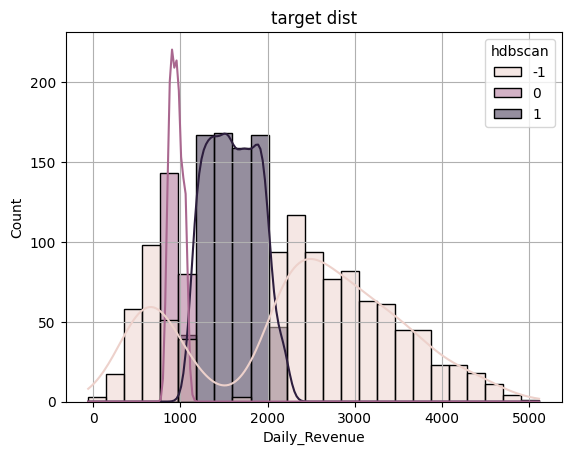

In [19]:
import hdbscan
from hdbscan import prediction

# Инициализация с сохранением данных для предсказания
clusterer = hdbscan.HDBSCAN(min_cluster_size=100, prediction_data=True).fit(scaled_df_train[[target]])

# Получение меток и уверенности в предсказании
clusters_train, strengths = prediction.approximate_predict(clusterer, scaled_df_train[[target]])
clusters_test, strengths = prediction.approximate_predict(clusterer, scaled_df_test[[target]])

clf_target ='hdbscan'

scaled_df_train['hdbscan'] = clusters_train
scaled_df_test['hdbscan'] = clusters_test
hdbscan_data = pd.concat([scaled_df_train, scaled_df_test])

plt.title('target dist')
plt.grid(which='major')
sns.histplot(data = hdbscan_data, x=target, kde=True, hue='hdbscan', bins=25)
plt.show()

In [20]:
def objective_multiclass(trial, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2025, stratify=y)
    
    params = {
        'iterations': trial.suggest_int('iterations', 100, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'random_strength': trial.suggest_float('random_strength', 1e-3, 10, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 10.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations', 1, 15),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'boosting_type': 'Plain',
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        'od_wait': trial.suggest_int('od_wait', 10, 50),
        'one_hot_max_size': trial.suggest_int('one_hot_max_size', 2, 255),
        'eval_metric': 'MultiClass',  # Изменено для многоклассовой классификации
        'task_type': 'CPU',
        'verbose': False,
        'random_state': 2025,
        'loss_function': 'MultiClass'  # Добавлено для многоклассовой классификации
    }
    
    if params['grow_policy'] == 'Lossguide':
        params['max_leaves'] = trial.suggest_int('max_leaves', 4, 64)
    elif params['grow_policy'] == 'Depthwise':
        params['max_depth'] = trial.suggest_int('max_depth', 2, 12)
    
    model = cat.CatBoostClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=(X_val, y_val),
        verbose=0
    )
    
    # Для многоклассового случая используем средний ROC AUC (One-vs-One или One-vs-Rest)
    y_proba = model.predict_proba(X_val)
    auc = metrics.roc_auc_score(y_val, y_proba, multi_class='ovo')  # или 'ovr'
    
    return auc

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective_multiclass(trial, 
                                     scaled_df_train[catboost_features], 
                                     scaled_df_train[clf_target]), 
                                     n_trials=50)
best_params = study.best_params

[I 2025-04-25 23:10:14,112] A new study created in memory with name: no-name-88385664-d7a7-4e16-8273-e54f891cf83c
[I 2025-04-25 23:10:14,393] Trial 0 finished with value: 0.8434736174347361 and parameters: {'iterations': 221, 'learning_rate': 0.28483365165855823, 'l2_leaf_reg': 0.5401484473838971, 'random_strength': 2.5974938178182896, 'bagging_temperature': 7.381880032180997, 'border_count': 44, 'min_data_in_leaf': 2, 'leaf_estimation_iterations': 3, 'grow_policy': 'Lossguide', 'od_type': 'Iter', 'od_wait': 50, 'one_hot_max_size': 138, 'max_leaves': 44}. Best is trial 0 with value: 0.8434736174347361.
[I 2025-04-25 23:10:15,644] Trial 1 finished with value: 0.8738571302385713 and parameters: {'iterations': 857, 'learning_rate': 0.06040745754387296, 'l2_leaf_reg': 0.0011523352298551154, 'random_strength': 0.004150073972271216, 'bagging_temperature': 2.1647588032016185, 'border_count': 138, 'min_data_in_leaf': 53, 'leaf_estimation_iterations': 5, 'grow_policy': 'Depthwise', 'od_type': '

In [21]:
clf = cat.CatBoostClassifier(random_state=2025, cat_features=cat_features, verbose=False, **best_params)
clf.fit(scaled_df_train[catboost_features], scaled_df_train[clf_target])

# Получаем предсказанные метки
clf_pred_train = clf.predict(scaled_df_train[catboost_features])
clf_pred_test = clf.predict(scaled_df_test[catboost_features])

# Получаем вероятности классов (необходимо для roc_auc)
clf_proba_train = clf.predict_proba(scaled_df_train[catboost_features])
clf_proba_test = clf.predict_proba(scaled_df_test[catboost_features])

print("TRAIN")
print(metrics.classification_report(scaled_df_train[clf_target], clf_pred_train))
print("TEST")
print(metrics.classification_report(scaled_df_test[clf_target], clf_pred_test))

# ROC AUC требует вероятностей, а не меток
print("Train ROC AUC =", metrics.roc_auc_score(
    scaled_df_train[clf_target], 
    clf_proba_train, 
    multi_class='ovr'  # или 'ovo'
))

print("Test ROC AUC =", metrics.roc_auc_score(
    scaled_df_test[clf_target], 
    clf_proba_test, 
    multi_class='ovr'  # или 'ovo'
))

TRAIN
              precision    recall  f1-score   support

          -1       0.91      0.89      0.90       686
           0       0.76      0.51      0.61       151
           1       0.81      0.92      0.86       503

    accuracy                           0.86      1340
   macro avg       0.83      0.77      0.79      1340
weighted avg       0.86      0.86      0.85      1340

TEST
              precision    recall  f1-score   support

          -1       0.86      0.82      0.84       341
           0       0.43      0.36      0.39        72
           1       0.75      0.83      0.79       247

    accuracy                           0.78       660
   macro avg       0.68      0.67      0.67       660
weighted avg       0.77      0.78      0.77       660

Train ROC AUC = 0.9611356715111112
Test ROC AUC = 0.9161969924748973


In [22]:
scaled_df_train_0 = scaled_df_train[scaled_df_train[clf_target] == 0]
scaled_df_train_1 = scaled_df_train[scaled_df_train[clf_target] == 1]
scaled_df_train_m1 = scaled_df_train[scaled_df_train[clf_target] == -1]

lr_0 = LinearRegression()
lr_0.fit(scaled_df_train_0[linear_features], scaled_df_train_0[target])
pred_train_0 = lr_0.predict(scaled_df_train_0[linear_features])

lr_1 = LinearRegression()
lr_1.fit(scaled_df_train_1[linear_features], scaled_df_train_1[target])
pred_train_1 = lr_1.predict(scaled_df_train_1[linear_features])

lr_m1 = LinearRegression()
lr_m1.fit(scaled_df_train_m1[linear_features], scaled_df_train_m1[target])
pred_train_m1 = lr_m1.predict(scaled_df_train_m1[linear_features])

print("train", scaled_df_train_0.shape, scaled_df_train_1.shape)
result_metrics = get_metrics(pd.concat([scaled_df_train_0[target], 
                                        scaled_df_train_m1[target], 
                                        scaled_df_train_1[target]]),
                             np.hstack([pred_train_0, pred_train_m1, pred_train_1]),
                              algorithm='segm_hdbscan_regression', dataset_type='train', 
                              res_df=result_metrics)


train (151, 10) (503, 10)
segm_hdbscan_regression, -- Type Dataset - train
R2 = 0.936523918780628
MSE = 60918.71144932604
RMSE = 246.81716198296672
MAE = 187.55525747972547
MAPE = 0.1485504763722264


In [23]:
clf.predict_proba(scaled_df_test[catboost_features])

array([[0.25175294, 0.04461588, 0.70363118],
       [0.56223377, 0.33690503, 0.10086121],
       [0.17983616, 0.04486757, 0.77529627],
       ...,
       [0.46129747, 0.03379765, 0.50490489],
       [0.97084855, 0.00746074, 0.02169072],
       [0.92004896, 0.0125812 , 0.06736984]])

In [24]:
clf.predict(scaled_df_test[catboost_features])

array([[ 1],
       [-1],
       [ 1],
       [ 1],
       [ 1],
       [-1],
       [ 1],
       [-1],
       [-1],
       [ 1],
       [-1],
       [ 0],
       [ 1],
       [ 0],
       [ 1],
       [-1],
       [ 1],
       [ 1],
       [ 1],
       [-1],
       [ 0],
       [-1],
       [ 0],
       [-1],
       [ 1],
       [ 1],
       [ 0],
       [ 1],
       [-1],
       [ 1],
       [-1],
       [-1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [-1],
       [-1],
       [ 1],
       [-1],
       [ 1],
       [-1],
       [ 1],
       [ 1],
       [-1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [ 1],
       [-1],
       [ 1],
       [-1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [-1],
       [ 0],
       [-1],
       [ 1],
       [-1],
       [ 1],
       [ 1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [ 1],

In [25]:
mask_0 = clf.predict_proba(scaled_df_test[catboost_features])[:, 1]>=0.5
mask_1 = clf.predict_proba(scaled_df_test[catboost_features])[:, 2]>=0.5
mask_m1 = clf.predict_proba(scaled_df_test[catboost_features])[:, 0]>=0.5
mask_doubting = ~mask_1 & ~mask_0 & ~mask_m1

scaled_df_test_0 = scaled_df_test.loc[mask_0]
scaled_df_test_1 = scaled_df_test.loc[mask_1]
scaled_df_test_m1 = scaled_df_test.loc[mask_m1]
scaled_df_test_doubting = scaled_df_test.loc[mask_doubting]

pred_test_0 = lr_0.predict(scaled_df_test_0[linear_features])
pred_test_1 = lr_1.predict(scaled_df_test_1[linear_features])
pred_test_m1 = lr_m1.predict(scaled_df_test_m1[linear_features])

if scaled_df_test_doubting.shape[0]>0:
     pred_test_doubting = (
          clf.predict_proba(scaled_df_test_doubting[catboost_features])[:,1]*lr_0.predict(scaled_df_test_doubting[linear_features]) +\
          clf.predict_proba(scaled_df_test_doubting[catboost_features])[:,2]*lr_1.predict(scaled_df_test_doubting[linear_features]) +\
          clf.predict_proba(scaled_df_test_doubting[catboost_features])[:,0]*lr_m1.predict(scaled_df_test_doubting[linear_features])
     )
else: 
     pred_test_doubting = np.array([])

result_metrics = get_metrics(pd.concat([scaled_df_test_0[target], 
                                        scaled_df_test_doubting[target], 
                                        scaled_df_test_1[target],
                                        scaled_df_test_m1[target]]),
                             np.hstack([pred_test_0, pred_test_doubting, pred_test_1, pred_test_m1]),
                              algorithm='segm_hdbscan_regression', dataset_type='test', 
                              res_df=result_metrics)

segm_hdbscan_regression, -- Type Dataset - test
R2 = 0.9116136265129897
MSE = 82890.56802587326
RMSE = 287.907221211753
MAE = 223.69695296515826
MAPE = 0.17903484850714815


In [26]:
result_metrics

,algorithm,dataset_type,R2,MSE,RMSE,MAE,MAPE
0,segm_kmeans2_regression,train,0.941133,56495.049855,237.686874,190.768328,0.155057
0,segm_kmeans2_regression,test,0.935906,60108.257078,245.169854,195.133469,0.139076
0,segm_gaus2_regression,train,0.938937,58602.664157,242.079871,194.853108,0.157866
0,segm_gaus2_regression,test,0.934443,61480.398672,247.952412,197.764941,0.141856
0,segm_hdbscan_regression,train,0.936524,60918.711449,246.817162,187.555257,0.148550
0,segm_hdbscan_regression,test,0.911614,82890.568026,287.907221,223.696953,0.179035
